In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re
import schedule
import time

In [9]:
# This function is used to graph and chart the stock data
def chart(data):
    #Load the Data
    df = pd.read_csv(data)
    
    #Create a simple moving average with a 30 day window
    SMA_30 = pd.DataFrame()
    SMA_30['Adj_Close_Price'] = df['Adj Close'].rolling(window = 30).mean()
    SMA_30
    
    # Short moving average for 100 days
    SMA_100 = pd.DataFrame()
    SMA_100['Adj_close_price'] = df['Adj Close'].rolling(window = 100).mean()
    SMA_100
    
    # Create a dataframe of all adj close prices
    data = pd.DataFrame()
    data['Date'] = df['Date']
    data['AAL_adj_close'] = df['Adj Close']
    data['SMA_30'] = SMA_30['Adj_Close_Price']
    data['SMA_100']= SMA_100['Adj_close_price']
    
    #Create a Function to signal when to buy and sell
    def buy_sell(data):
        sig_price_buy = []
        sig_price_sell = []
        flag = -1

        for i in range(len(data)):
            if data['SMA_30'][i] > data['SMA_100'][i]:
                if flag != 1:
                    sig_price_buy.append(data['AAL_adj_close'][i])
                    sig_price_sell.append(np.nan)
                    flag = 1
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            elif data['SMA_30'][i] < data['SMA_100'][i]:
                if flag !=0:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(data['AAL_adj_close'][i])
                    flag = 0
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)

        return (sig_price_buy, sig_price_sell)
    
    #store the buy and sell data into a variable
    buy_sell = buy_sell(data)
    data['buy_signal_price'] = buy_sell[0]
    data['sell_signal_price']=buy_sell[1]
    
    #Looking for the dates of the buy signals
    buy_dates = data.loc[data['buy_signal_price']>0]
    
    #Looking for the dates of the sell signals
    sell_dates = data.loc[data['sell_signal_price']>0]
    
    #Dropping uneccessary columns
    buy_dates.drop(columns = ['sell_signal_price', 'SMA_30', 'SMA_100'], inplace = True)
    sell_dates.drop(columns = ['buy_signal_price', 'SMA_30', 'SMA_100'], inplace = True)
    
    # DF of dates with prices
    dates = pd.concat([buy_dates, sell_dates],sort = True)
    
    # Now to organize by the dates, drop adj_close price column, and make date the index
    dates.sort_values(by = 'Date', inplace = True)
    dates.drop(columns = ['AAL_adj_close'],inplace = True)
    dates.set_index('Date', inplace = True)

    #visualize data and strategy to buy and sell stock
    ab = plt.figure(figsize=(20,12))
    combined.Date = pd.to_datetime(combined.Date).dt.strftime('%b %d %Y')
    last_date = combined['Date'].iloc[-1]
    first_date = combined['Date'].iloc[0]
    plt.plot(data['AAL_adj_close'],label = 'PMAC', alpha = 0.35)
    plt.plot(data['SMA_30'], label = 'SMA30', alpha = 0.35)
    plt.plot(data['SMA_100'],label = 'SMA100', alpha = 0.35)
    plt.scatter(data.index, data['buy_signal_price'],label = 'Buy',marker = '^', color = 'green')
    plt.scatter(data.index, data['sell_signal_price'], label = 'Sell', marker = 'v', color = 'red')
    plt.title('{} adj close price history buy and sell signals'.format(x))
    plt.xlabel('{} - {}'.format(first_date, last_date))
    plt.ylabel('Adj close price USD')
    plt.legend()
    plt.show()
    print(dates)

    return 


In [8]:
# Webscraping method to pull past 5 dates. 
def new_data(stock_name):
    # Now that we saved our chart from yahoo.com, we can scrape new data to update our csv file
    # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.
    page = requests.get('https://finance.yahoo.com/quote/{}/history?p={}'.format(stock_name, stock_name))
    soup = BeautifulSoup(page.content, 'html.parser')
    info = soup.find('table', class_ = 'W(100%) M(0)')
    columns = info.find_all('td')

    # First new date
    new_date = str(columns[0])
    new_date = new_date[-24:-12]
    
    # Retrieving new open price
    new_open_price = str(columns[1])
    new_open_price = new_open_price[-26:-12]
    new_open_price = new_open_price.replace("55","")
    new_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_open_price)
    new_open_price = float(new_open_price)
    
    # Retrieving new adjusted close price
    new_adj_close_price = str(columns[5])
    new_adj_close_price = new_adj_close_price[-26:-8]
    new_adj_close_price = new_adj_close_price.replace("63","")
    new_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_adj_close_price)
    new_adj_close_price = float(new_adj_close_price)


    # Second Date
#     second_date = str(columns[7])
#     second_date = second_date[-24:-12]
    
#     # Second open price
#     second_open_price = str(columns[8])
#     second_open_price = second_open_price[-26:-12]
#     second_open_price = second_open_price.replace("70","")
#     second_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",second_open_price)
#     second_open_price = float(second_open_price)
    
#     # Second adjusted close price
#     second_adj_close_price = str(columns[12])
#     second_adj_close_price = second_adj_close_price[-26:-12]
#     second_adj_close_price = second_adj_close_price.replace("78","")
#     second_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",second_adj_close_price)
#     second_adj_close_price = float(second_adj_close_price)

#     # Third Date
#     third_date = str(columns[14])
#     third_date = third_date[-24:-12]
    
#     # Third open price
#     third_open_price = str(columns[15])
#     third_open_price = third_open_price[-26:-8]
#     third_open_price = third_open_price.replace("85","")
#     third_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",third_open_price)
#     third_open_price = float(third_open_price)
    
#     # Third adjusted close price
#     third_adj_close_price = str(columns[19])
#     third_adj_close_price = third_adj_close_price[-26:-8]
#     third_adj_close_price = third_adj_close_price.replace("93","")
#     third_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",third_adj_close_price)
#     third_adj_close_price = float(third_adj_close_price)

#     # Fouth Date
#     fourth_date = str(columns[21])
#     fourth_date = fourth_date[-24:-12]
    
#     # Fourth open price
#     fourth_open_price = str(columns[22])
#     fourth_open_price = fourth_open_price[-26:-12]
#     fourth_open_price = fourth_open_price.replace("100","")
#     fourth_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",fourth_open_price)
#     fourth_open_price = float(fourth_open_price)
    
#     # Fourth adjusted close price
#     fourth_adj_close_price = str(columns[26])
#     fourth_adj_close_price = fourth_adj_close_price[-26:-12]
#     fourth_adj_close_price = fourth_adj_close_price.replace("108","")
#     fourth_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",fourth_adj_close_price)
#     fourth_adj_close_price = float(fourth_adj_close_price)

#     # Fifth Date
#     fifth_date = str(columns[28])
#     fifth_date = fifth_date[-24:-12]
    
#     # Fifth open price
#     fifth_open_price = str(columns[29])
#     fifth_open_price = fifth_open_price[-26:-12]
#     fifth_open_price = fifth_open_price.replace("115","")
#     fifth_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",fifth_open_price)
#     fifth_open_price = float(fifth_open_price)
    
#     # Fifth adjusted close price
#     fifth_adj_close_price = str(columns[33])
#     fifth_adj_close_price = fifth_adj_close_price[-26:-12]
#     fifth_adj_close_price = fifth_adj_close_price.replace("123","")
#     fifth_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",fifth_adj_close_price)
#     fifth_adj_close_price = float(fifth_adj_close_price)
# second_date, third_date, fourth_date, fifth_date


    # Creating column_info dictionary to be uploaded to new df
    column_info = {'Date':[new_date],
            'Open':[new_open_price],
            'Adj Close':[new_adj_close_price]}
    
    # New df name of new_information. This is the newly webscraped data
    new_information = pd.DataFrame(data = column_info)
    
    # Change the 'Date' type to datetime so it can concat with pre-existing csv file
    new_information['Date'] = pd.to_datetime(new_information.Date)    
    
    return new_information

### The cell below combines the webscraping function as well as the SMA and graphing function for ease of use

Enter Stock: 


 AAPL


/Users/joseph/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


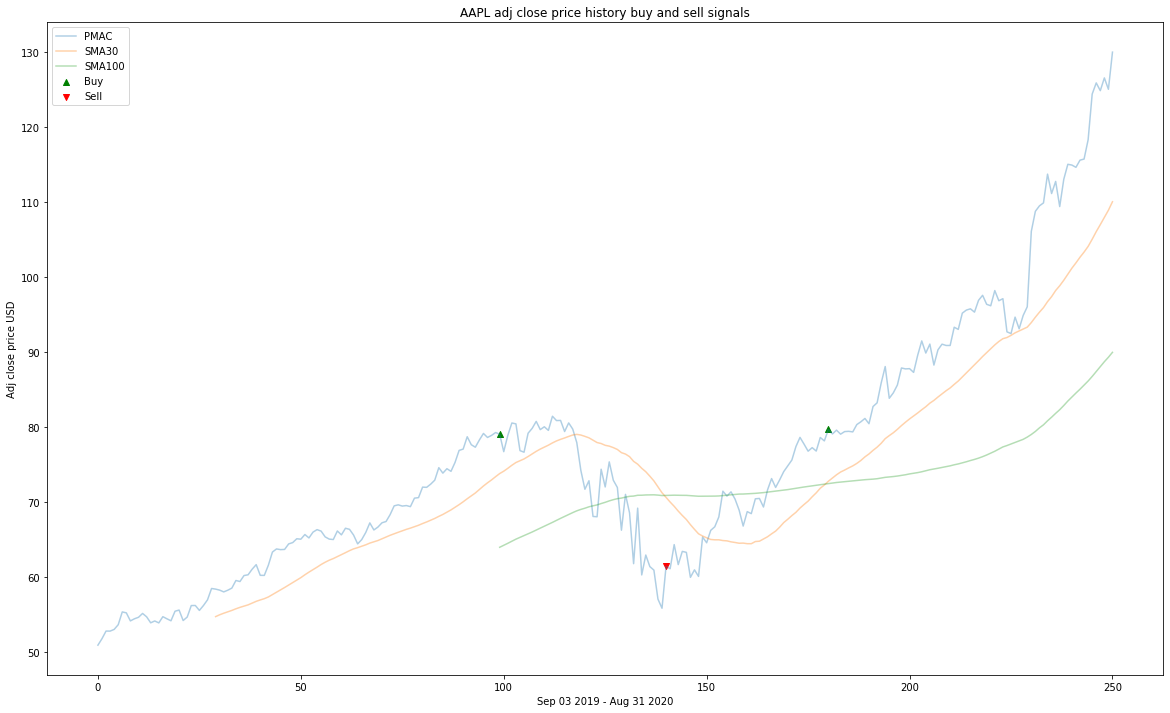

            buy_signal_price  sell_signal_price
Date                                           
2020-01-24         79.032265                NaN
2020-03-24               NaN          61.442596
2020-05-20         79.663872                NaN


,buy_signal_price,sell_signal_price
Date,,
2020-01-24,79.032265,NaN
2020-03-24,NaN,61.442596
2020-05-20,79.663872,NaN


In [9]:
# Enter the stock you would like to see from your library
print('Enter Stock: ')
x = input()

# Create a df from the new_data function that will retrieve the stock information you enter
new_info = new_data(f'{x}')

# When the data is scraped, the time 00:00:00 also comes with it. That will not concat with our data
# so we need to get rid of it
new_info['Date'] = pd.to_datetime(new_info['Date']).dt.date

# Make sure the Date type is datetime so it concats properly
new_info['Date'] = pd.to_datetime(new_info.Date)

# Read in our existing data
stock_chart = pd.read_csv('{}.csv'.format(x))

# Make sure the Date type is datetime so it concats properly
stock_chart['Date'] = pd.to_datetime(stock_chart.Date)

# Now we combined our newly webscraped data with our csv file
combined = pd.concat([stock_chart, new_info], sort = False)
combined.sort_values(by = 'Date', inplace = True)
combined.reset_index(drop = True, inplace = True)
combined.drop_duplicates(subset = ['Date'], inplace = True)
combined = combined[['Date', 'Open', 'Adj Close']]

# Save the combined data to a csv file
combined.to_csv(f'{x}.csv', index = False)

# Now to use our chart function to get a visual representaion of our data
chart(f'{x}.csv')

### Next goal is to create a code to automatically run each stock when the market opens, then every hour on the hour

### On Aug 31, 2020, many companies split their stocks and my code broke. The second line on yahoo finance gave the date and the split ratio. The split ratio cannot be used in the process of craping, so creating an automated function to pull the first line of data is important.

In [55]:
pd.read_csv('AAPL.csv')

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,51.607498,51.744999,51.055000,51.424999,50.919777,80092000
1,2019-09-04,52.097500,52.369999,51.830002,52.297501,51.783714,76752400
2,2019-09-05,53.000000,53.492500,52.877499,53.320000,52.796162,95654800
3,2019-09-06,53.512501,53.605000,53.127499,53.314999,52.791210,77449200
4,2019-09-09,53.709999,54.110001,52.767502,53.542500,53.016479,109237600
...,...,...,...,...,...,...,...
245,2020-08-21,119.262497,124.867500,119.250000,124.370003,124.370003,338054800
246,2020-08-24,128.697495,128.785004,123.937500,125.857498,125.857498,345937600
247,2020-08-25,124.697502,125.180000,123.052498,124.824997,124.824997,211495600
248,2020-08-26,126.180000,126.992500,125.082497,126.522499,126.522499,163022400


In [56]:
pd.read_csv('TSLA.csv')

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,44.816002,45.790001,44.632000,45.001999,45.001999,26770500
1,2019-09-04,45.377998,45.692001,43.841999,44.136002,44.136002,28805000
2,2019-09-05,44.500000,45.959999,44.169998,45.916000,45.916000,36976500
3,2019-09-06,45.439999,45.928001,45.034000,45.490002,45.490002,20947000
4,2019-09-09,46.000000,46.751999,45.846001,46.358002,46.358002,24013500
...,...,...,...,...,...,...,...
245,2020-08-21,408.951996,419.097992,405.010010,409.996002,409.996002,107448000
246,2020-08-24,425.256012,425.799988,385.503998,402.839996,402.839996,100318000
247,2020-08-25,394.977997,405.589996,393.600006,404.667999,404.667999,53294500
248,2020-08-26,412.000000,433.200012,410.726013,430.634003,430.634003,71197000


Creating Function to webscrape multiple stocks

In [2]:
def get_info(stocks):
    # Webscraping method to pull past 5 dates. 
    # Now that we saved our chart from yahoo.com, we can scrape new data to update our csv file
    # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.

    stocks = ['AAPL','TSLA']
    for stock_name in stocks:
        stock_name = stock_name.strip()
        print(stock_name)
        page = requests.get('https://finance.yahoo.com/quote/{}/history?p={}'.format(stock_name, stock_name))
        soup = BeautifulSoup(page.content, 'html.parser')
        info = soup.find('table', class_ = 'W(100%) M(0)')
        columns = info.find_all('td')

        # First new date
        new_date = str(columns[0])
        new_date = new_date[-24:-12]

        # Retrieving new open price
        new_open_price = str(columns[1])
        new_open_price = new_open_price[-26:-12]
        new_open_price = new_open_price.replace("55","")
        new_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_open_price)
        new_open_price = float(new_open_price)

        # Retrieving new adjusted close price
        new_adj_close_price = str(columns[5])
        new_adj_close_price = new_adj_close_price[-26:-8]
        new_adj_close_price = new_adj_close_price.replace("63","")
        new_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_adj_close_price)
        new_adj_close_price = float(new_adj_close_price)

        # Creating column_info dictionary to be uploaded to new df
        column_info = {'Date':[new_date],
                'Open':[new_open_price],
                'Adj Close':[new_adj_close_price]}

        # New df name of new_information. This is the newly webscraped data
        new_info = pd.DataFrame(data = column_info)
        new_info['Date'] = pd.to_datetime(new_info['Date']).dt.date


        # Read in our existing data
        stock_chart = pd.read_csv(f'{stock_name}.csv')
        stock_chart['Date'] = pd.to_datetime(stock_chart['Date']).dt.date


        # Make sure the Date type is datetime so it concats properly

        # Now we combined our newly webscraped data with our csv file
        combined = pd.concat([stock_chart, new_info], sort = False)
        combined.sort_values(by = 'Date', inplace = True)
        combined.reset_index(drop = True, inplace = True)
        combined.drop_duplicates(subset = ['Date'], inplace = True)
        combined = combined[['Date', 'Open', 'Adj Close']]
        # Save the combined data to a csv file
        combined.to_csv(f'{stock_name}.csv', index = False)

In [67]:
get_info('stocks')

AAPL
TSLA


In [68]:
pd.read_csv('AAPL.csv')

,Date,Open,Adj Close
0,2019-09-03,51.607498,50.919777
1,2019-09-04,52.097500,51.783714
2,2019-09-05,53.000000,52.796162
3,2019-09-06,53.512501,52.791210
4,2019-09-09,53.709999,53.016479
...,...,...,...
246,2020-08-24,128.697495,125.857498
247,2020-08-25,124.697502,124.824997
248,2020-08-26,126.180000,126.522499
249,2020-08-27,127.142502,125.010002


In [69]:
pd.read_csv('TSLA.csv')

,Date,Open,Adj Close
0,2019-09-03,44.816002,45.001999
1,2019-09-04,45.377998,44.136002
2,2019-09-05,44.500000,45.916000
3,2019-09-06,45.439999,45.490002
4,2019-09-09,46.000000,46.358002
...,...,...,...
246,2020-08-24,425.256012,402.839996
247,2020-08-25,394.977997,404.667999
248,2020-08-26,412.000000,430.634003
249,2020-08-27,436.092010,447.750000


In [16]:
stocks = ['AAPL','TSLA','JPY=X','XRP-USD']
def get_info():
    # Webscraping method to pull past 5 dates. 
    # Now that we saved our chart from yahoo.com, we can scrape new data to update our csv file
    # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.

    stocks = ['AAPL','TSLA','JPY=X','XRP-USD']
    for stock_name in stocks:
        stock_name = stock_name.strip()
        print(stock_name)
        page = requests.get('https://finance.yahoo.com/quote/{}/history?p={}'.format(stock_name, stock_name))
        soup = BeautifulSoup(page.content, 'html.parser')
        info = soup.find('table', class_ = 'W(100%) M(0)')
        columns = info.find_all('td')

        # First new date
        new_date = str(columns[0])
        new_date = new_date[-24:-12]

        # Retrieving new open price
        new_open_price = str(columns[1])
        new_open_price = new_open_price[-26:-12]
        new_open_price = new_open_price.replace("55","")
        new_open_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_open_price)
        new_open_price = float(new_open_price)

        # Retrieving new adjusted close price
        new_adj_close_price = str(columns[5])
        new_adj_close_price = new_adj_close_price[-26:-8]
        new_adj_close_price = new_adj_close_price.replace("63","")
        new_adj_close_price = re.sub('"|a|r|e|-|c|>|<|/|s|p|t|i|d|=|,',"",new_adj_close_price)
        new_adj_close_price = float(new_adj_close_price)

        # Creating column_info dictionary to be uploaded to new df
        column_info = {'Date':[new_date],
                'Open':[new_open_price],
                'Adj Close':[new_adj_close_price]}

        # New df name of new_information. This is the newly webscraped data
        new_info = pd.DataFrame(data = column_info)
        new_info['Date'] = pd.to_datetime(new_info['Date']).dt.date


        # Read in our existing data
        stock_chart = pd.read_csv(f'{stock_name}.csv')
        stock_chart['Date'] = pd.to_datetime(stock_chart['Date']).dt.date


        # Make sure the Date type is datetime so it concats properly

        # Now we combined our newly webscraped data with our csv file
        combined = pd.concat([stock_chart, new_info], sort = False)
        combined.sort_values(by = 'Date', inplace = True)
        combined.reset_index(drop = True, inplace = True)
        combined.drop_duplicates(subset = ['Date'], inplace = True)
        combined = combined[['Date', 'Open', 'Adj Close']]
        # Save the combined data to a csv file
        combined.to_csv(f'{stock_name}.csv', index = False)


In [18]:
get_info()

AAPL
TSLA


In [ ]:
# Creating schedule to collect new data every weekday the top of the hour.
schedule.every().monday.at("09:00").do(get_info)
schedule.every().monday.at("10:00").do(get_info)
schedule.every().monday.at("11:00").do(get_info)
schedule.every().monday.at("12:00").do(get_info)
schedule.every().monday.at("13:00").do(get_info)
schedule.every().monday.at("14:00").do(get_info)
schedule.every().monday.at("15:00").do(get_info)
schedule.every().monday.at("16:00").do(get_info)
schedule.every().monday.at("17:00").do(get_info)

schedule.every().tuesday.at("09:00").do(get_info)
schedule.every().tuesday.at("10:00").do(get_info)
schedule.every().tuesday.at("11:00").do(get_info)
schedule.every().tuesday.at("12:00").do(get_info)
schedule.every().tuesday.at("13:00").do(get_info)
schedule.every().tuesday.at("14:00").do(get_info)
schedule.every().tuesday.at("15:00").do(get_info)
schedule.every().tuesday.at("16:00").do(get_info)
schedule.every().tuesday.at("17:00").do(get_info)

schedule.every().wednesday.at("09:00").do(get_info)
schedule.every().wednesday.at("10:00").do(get_info)
schedule.every().wednesday.at("11:00").do(get_info)
schedule.every().wednesday.at("12:00").do(get_info)
schedule.every().wednesday.at("13:00").do(get_info)
schedule.every().wednesday.at("14:00").do(get_info)
schedule.every().wednesday.at("15:00").do(get_info)
schedule.every().wednesday.at("16:00").do(get_info)
schedule.every().wednesday.at("17:00").do(get_info)

schedule.every().thursday.at("09:00").do(get_info)
schedule.every().thursday.at("10:00").do(get_info)
schedule.every().thursday.at("11:00").do(get_info)
schedule.every().thursday.at("12:00").do(get_info)
schedule.every().thursday.at("13:00").do(get_info)
schedule.every().thursday.at("14:00").do(get_info)
schedule.every().thursday.at("15:00").do(get_info)
schedule.every().thursday.at("16:00").do(get_info)
schedule.every().thursday.at("17:00").do(get_info)

schedule.every().friday.at("09:00").do(get_info)
schedule.every().friday.at("10:00").do(get_info)
schedule.every().friday.at("11:00").do(get_info)
schedule.every().friday.at("12:00").do(get_info)
schedule.every().friday.at("13:00").do(get_info)
schedule.every().friday.at("14:00").do(get_info)
schedule.every().friday.at("15:00").do(get_info)
schedule.every().friday.at("16:00").do(get_info)
schedule.every().friday.at("17:00").do(get_info)




while True:
    schedule.run_pending()
    time.sleep(1)